In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import warnings
import time
import math
import random
warnings.filterwarnings(action='ignore')

In [2]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

df = pd.read_csv('./Data/kodex200_data.csv') # 데이터 불러오기
close = np.array(df['종가'])
logreturn = np.diff(np.log(close)) # Min-max 스케일러 대신, 로그변환을 통한 스케일링

csum_logreturn = logreturn.cumsum() # 누적로그수익률누적로그수익률

In [4]:
# 원하는 날짜 get
# 2020-02-19 : 1753 - short down
# 2020-12-21 : 1962 - short up
# 2016-12-08 : 969  - long up
# 2018-06-05 : 1334 - long down
# 2020-03-20 : 1775 - downandup
#index_num = df.index[df['날짜'] == '2020-03-20'] # '2020-02-19', '2016-12-08', '2018-06-05', 2020-12-21
# Setup : 5년을 1200, 4년 960, 3년 720, 1년 240, 6개월 120, 3개월 60, 1개월 20
# 이전 3년 데이터 slicing

index_num = 1775 #!!!
train_num = 1200 # 5년
train_num2 = 960 # 4년
df_short_up = df.iloc[1962  - train_num : 1962]
df_short_down = df.iloc[1753 - train_num : 1753]
df_long_up = df.iloc[969 - train_num2 : 969]
df_long_down = df.iloc[1334 - train_num2 : 1334]
df_downandup = df.iloc[1775 - train_num : 1775]

In [5]:
train_close = np.array(df_short_down['종가'])
train_set = np.diff(np.log(train_close)).cumsum() # Min-max 스케일러 대신, 로그변환을 통한 스케일링, 누적로그수익률

In [6]:
idx_num = 1771
test_m1 = df.iloc[idx_num : idx_num+20]
test_m3 = df.iloc[idx_num : idx_num+60]
test_m6 = df.iloc[idx_num : idx_num+120]

In [7]:
test_m1

,날짜,NAV,시가,고가,저가,종가,거래량,괴리율,추적오차율
1771,2020-03-20,21779.11,20825,21795,20385,21795,40017034,0.07,0.55
1772,2020-03-23,20593.25,20230,21020,20190,20515,22468822,-0.38,0.55
1773,2020-03-24,22433.78,21100,22420,20795,22420,19045947,-0.06,0.59
1774,2020-03-25,23694.29,23090,23760,22780,23705,35369755,0.05,0.60
1775,2020-03-26,23345.11,23695,24050,22885,23245,16524210,-0.43,0.60
1776,2020-03-27,23795.57,24230,24350,23010,23805,18297580,0.04,0.60
1777,2020-03-30,23717.25,23060,23910,22915,23665,15830905,-0.22,0.60
1778,2020-03-31,24157.52,23815,24140,23640,24085,11805006,-0.30,0.60
1779,2020-04-01,23105.09,23870,24145,22955,22955,18755243,-0.65,0.60
1780,2020-04-02,23655.28,23075,23665,22755,23660,14879115,0.02,0.61


In [8]:
close_m1 = np.array(test_m1['종가'])
close_m1 = np.diff(np.log(close_m1)).cumsum()

In [9]:
test_set = close_m1

데이터 분리 및 사용

In [10]:
# # Train, Test 데이터 분리
# train_size = 0.8
# n_train = int(train_size*csum_logreturn.shape[0]) #train size 따른 데이터 갯수
# train_set = csum_logreturn[0: n_train]
# test_set = csum_logreturn[n_train:]

# 모델 파라미터 정의
batch = 100
input_window = 4 # window size
output_size = 1 # output 차원
input_size = 1 # feature 개수
hidden_size = 25
num_layers = 1 

def sliding_windows(data, input_window):
    x = []
    y = []

    for i in range(len(data)-input_window-1):
        _x = data[i:(i+input_window)]
        _y = data[i+input_window]
        x.append(_x)
        y.append(_y)
    
    x = np.array(x).reshape(-1, input_window, 1)
    y = np.array(y).reshape(-1, 1)

    return torch.FloatTensor(np.array(x)), torch.FloatTensor(np.array(y))

trainX_tensor, trainY_tensor = sliding_windows(train_set, input_window)
testX_tensor, testY_tensor = sliding_windows(test_set, input_window)

print(f"trainX:{trainX_tensor.shape}, trainY:{trainY_tensor.shape}, testX:{testX_tensor.shape}, testY:{testY_tensor.shape}")

# 데이터셋으로 묶음
dataset = TensorDataset(trainX_tensor, trainY_tensor)
test_set_tensor = TensorDataset(testX_tensor, testY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

trainX:torch.Size([1194, 4, 1]), trainY:torch.Size([1194, 1]), testX:torch.Size([14, 4, 1]), testY:torch.Size([14, 1])


LSTM Model

In [11]:
class LSTM(nn.Module):
    # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)

        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, output_size) #fully connected last layer
        self.relu = nn.ReLU()

    def forward(self, x) :
        # Propagate input through LSTM
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
           
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state

        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out

훈련 함수

In [12]:
def train(model, train_data, optimizer, criterion, scheduler, epoch):
    model.train() 
    total_loss = 0.
    start_time = time.time()
    for batch_idx, samples in enumerate(train_data):

        data, targets = samples

        #print("----------")
        output = model(data)
        #print(f"data:{data.shape} output:{output.shape},targets:{targets.shape}")

        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 2 == 0:
            elapsed_time = time.time() - start_time
            avg_loss = total_loss / (batch_idx + 1)
            print(f"| epoch {epoch:3d} | {batch_idx:5d}/{len(train_data):5d} batches | "
                f"lr {scheduler.get_lr()[0]:.10f} | {elapsed_time:6.2f} ms | "
                f"loss {avg_loss:.7f}")

    scheduler.step()

모델 평가 함수

In [13]:
def evaluate(eval_model, criterion, testX, testY):
    eval_model.eval() # 평가 모드로 전환
    total_loss = 0.
    with torch.no_grad():
        output = eval_model(testX)    
        total_loss += len(testX[0])* criterion(output, testY).cpu().item()
    return total_loss / len(testX)

테스트 예측 함수

In [14]:
def forecast_seq(model, testX, testY):
    # 예측 결과와 실제 값 반환
    start_timer = time.time()
    model.eval() 
    forecast = model(testX).data.numpy()
    actual = testY.data.numpy()
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast, actual

데이터 준비 및 훈련

In [15]:
train_data = dataloader
model = LSTM().to(device)

모델 파라미터

In [16]:
criterion = nn.MSELoss() # Loss function
lr = 0.05 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs = 5 # Number of epochs

Training loop

In [17]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    train(model, train_data, optimizer, criterion, scheduler, epoch)

    if(epoch % epochs == 0): # 마지막 에포치 끝난 후 모델 평가
        val_loss = evaluate(model, criterion, testX_tensor, testY_tensor)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)

    else:   
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()

| epoch   1 |     0/   11 batches | lr 0.0500000000 |   0.01 ms | loss 0.0161553
| epoch   1 |     2/   11 batches | lr 0.0500000000 |   0.02 ms | loss 0.1361231
| epoch   1 |     4/   11 batches | lr 0.0500000000 |   0.03 ms | loss 0.0885786
| epoch   1 |     6/   11 batches | lr 0.0500000000 |   0.04 ms | loss 0.0666666
| epoch   1 |     8/   11 batches | lr 0.0500000000 |   0.05 ms | loss 0.0549639
| epoch   1 |    10/   11 batches | lr 0.0500000000 |   0.06 ms | loss 0.0471904
--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.06s
--------------------------------------------------------------------------------
| epoch   2 |     0/   11 batches | lr 0.0428687500 |   0.01 ms | loss 0.0072747
| epoch   2 |     2/   11 batches | lr 0.0428687500 |   0.02 ms | loss 0.0093920
| epoch   2 |     4/   11 batches | lr 0.0428687500 |   0.03 ms | loss 0.0096467
| epoch   2 |     6/   11 batches | lr 0.0428687500 |   0.03 ms | loss 0.00

In [18]:
test_result, truth = forecast_seq(model, testX_tensor, testY_tensor)

0.00099945068359375 sec


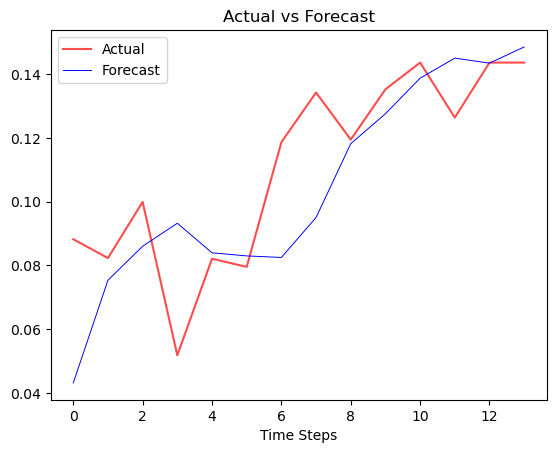

In [19]:
plt.plot(truth, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()